### Импортируем необходимые библиотеки

In [1]:
import pandas as pd
from operator import attrgetter
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm.auto import tqdm
from scipy.stats import norm
from scipy.stats import kstest

import warnings
warnings.filterwarnings('ignore')

### Задание 1

In [2]:
registration = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-d-androsova/shared/problem1-reg_data.csv', sep=';')
authorisation = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-d-androsova/shared/problem1-auth_data.csv', sep=';')
test_data = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-d-androsova/FINAL PROJECT/task.csv', sep=';')

#### Посмотрим на данные и преобразуем форматы, где это необходимо

In [3]:
print(registration.shape[0])
print(registration.isna().sum().sum())
print(registration.duplicated().sum())

1000000
0
0


In [4]:
registration.reg_ts = registration.reg_ts.apply(pd.Timestamp.fromtimestamp)
registration.reg_ts = pd.to_datetime(registration.reg_ts).dt.date
registration.head()

,reg_ts,uid
0,1998-11-18,1
1,1999-07-23,2
2,2000-01-14,3
3,2000-05-28,4
4,2000-09-16,5


In [5]:
print(authorisation.shape[0])
print(authorisation.isna().sum().sum())
print(authorisation.duplicated().sum())

9601013
0
0


In [6]:
authorisation.auth_ts = authorisation.auth_ts.apply(pd.Timestamp.fromtimestamp)
authorisation.auth_ts = pd.to_datetime(authorisation.auth_ts).dt.date
authorisation.head()

,auth_ts,uid
0,1998-11-18,1
1,1999-07-23,2
2,1999-07-25,2
3,1999-07-31,2
4,1999-08-05,2


#### Посчитаем Retention Rate для когорт пользователей (основаны на дате регистрации) по дням. Функция считает метрику как для всех данных, так и для сэмпла данных в зависимости от фильтра пользователя.

In [7]:
def computing_retention(start_date, end_date, period_start, period_end):
    
    info = authorisation.merge(registration, how='inner', on='uid')
    info.reg_ts = pd.to_datetime(info.reg_ts)
    info.auth_ts = pd.to_datetime(info.auth_ts)
    
    info = info[((pd.to_datetime(info.reg_ts) >= pd.to_datetime(start_date)) & (pd.to_datetime(info.reg_ts) <= pd.to_datetime(end_date)))]
    
    for_cohorts = info.groupby(['reg_ts', 'auth_ts'], as_index=False).uid.nunique()
    for_cohorts = for_cohorts.rename(columns={'uid': 'users_num', 
                                                'reg_ts': 'reg_date', 
                                                'auth_ts': 'auth_date'})
    
    for_cohorts['period'] = (pd.to_datetime(for_cohorts.auth_date).dt.to_period('D') - pd.to_datetime(for_cohorts.reg_date).dt.to_period('D')).apply(attrgetter('n')) 
    for_cohorts = for_cohorts[['reg_date', 'period', 'users_num']]
    
    for_cohorts = for_cohorts[(for_cohorts.period >= int(period_start)) & (for_cohorts.period <= int(period_end))]
    
    size_of_cohorts = for_cohorts[['reg_date', 'users_num']].groupby('reg_date', as_index=False).first()
    for_cohorts = for_cohorts.merge(size_of_cohorts, on='reg_date') \
                             .rename(columns={'users_num_x': 'users_num', 'users_num_y': 'cohort_size'}) 
    
    for_cohorts['retention'] = for_cohorts.users_num / for_cohorts.cohort_size
    
    cohorts_retention = for_cohorts[['reg_date', 'period', 'retention']] \
                         .pivot(index='period', 
                                columns='reg_date', 
                                values='retention') 
    
    # Визуализация
    
    plt.figure(figsize=(24, 16))
    plt.title('Cohorts: User Retention')
    plot = sns.heatmap(cohorts_retention.T, 
                mask= cohorts_retention.T.isnull(), 
                annot=True, 
                cmap=sns.cubehelix_palette(as_cmap=True),
                fmt='.1%')
    plot.set_yticklabels(cohorts_retention.columns.strftime('%Y-%m-%d'), fontsize=10)
    plt.show()

In [8]:
start_date = input("Введите начальную дату формата 'ГГ-ММ-ДД': ")
end_date = input("Введите конечную дату формата 'ГГ-ММ-ДД': ")
period_start = input("Введите номер начального retention period: ")
period_end = input("Введите номер конечного retention period: ")

Введите начальную дату формата 'ГГ-ММ-ДД': 2018-01-01
Введите конечную дату формата 'ГГ-ММ-ДД': 2018-01-10
Введите номер начального retention period: 0
Введите номер конечного retention period: 7


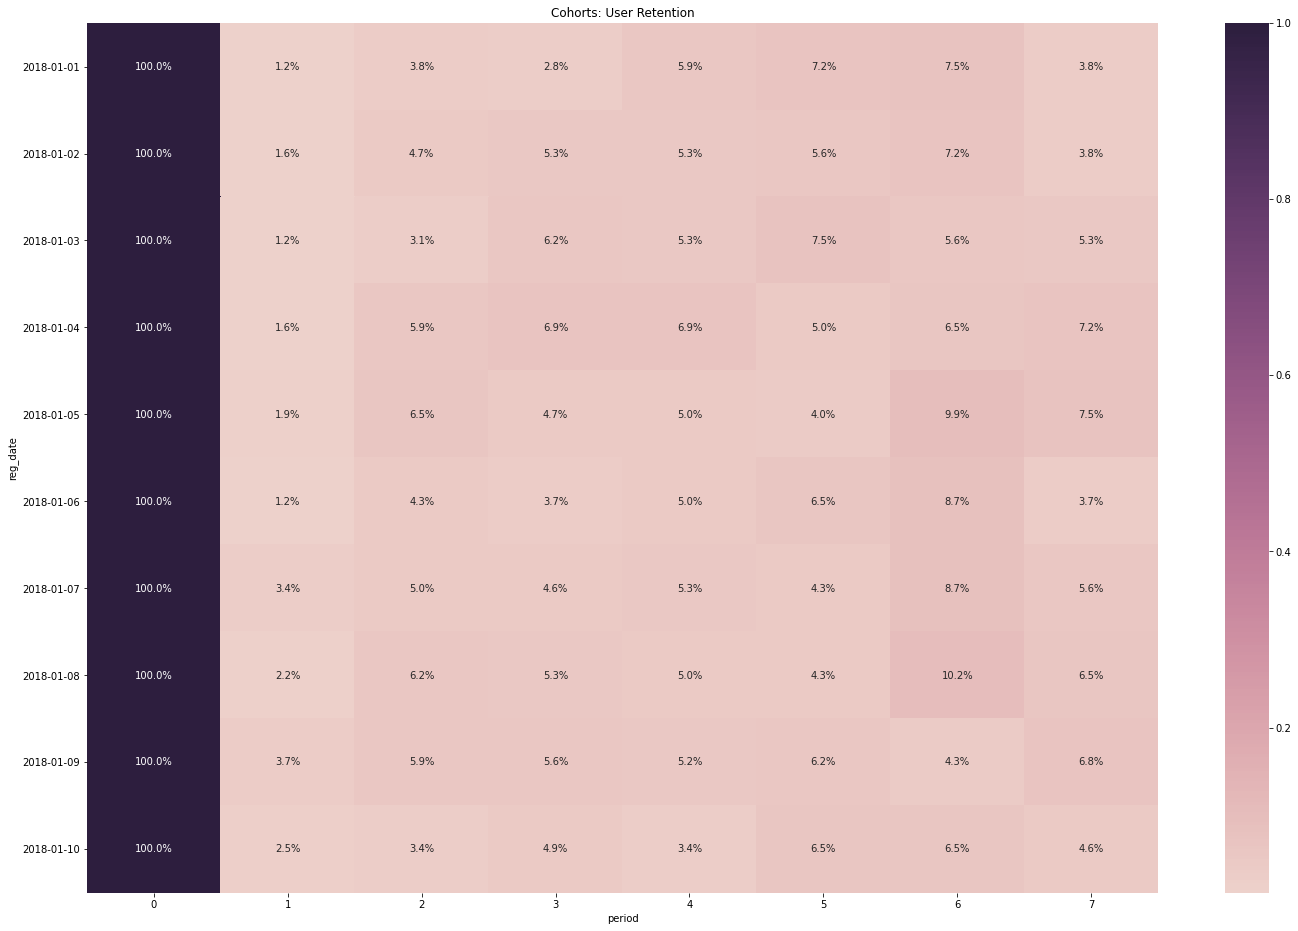

In [9]:
retention = computing_retention(start_date = start_date, end_date = end_date, period_start = period_start, period_end = period_end)
retention

### Задание 2

#### Посмотрим на данные

In [10]:
test_data.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [11]:
print(test_data.shape[0])
print(test_data.isna().sum().sum())
print(test_data.nunique())

404770
0
user_id      404770
revenue        1477
testgroup         2
dtype: int64


#### Разделим данные на датафреймы в зависимости от группы эксперимента и факта наличия оплаты покупок 

In [12]:
a_group = test_data[test_data.testgroup == 'a']
b_group = test_data[test_data.testgroup == 'b']
a_group_pay = test_data[(test_data.testgroup == 'a') & (test_data.revenue > 0)]
b_group_pay = test_data[(test_data.testgroup == 'b') & (test_data.revenue > 0)]

#### Проверим уловие задачи на истинность

In [13]:
print('ARPU in group a:', round(a_group.revenue.sum()/a_group.user_id.nunique(), 2))
print('ARPU in group b:', round(b_group.revenue.sum()/b_group.user_id.nunique(), 2))

ARPU in group a: 25.41
ARPU in group b: 26.75


In [14]:
print('ARPU в группе b больше ARPU в группе a на', round((26.75 - 25.41)/26.75*100, 2),'%')

ARPU в группе b больше ARPU в группе a на 5.01 %


In [15]:
print(f'В контрольной группе всего {a_group.shape[0]} пользователей, из которых {a_group_pay.shape[0]} - платящие')
print(f'В тестовой группе всего {b_group.shape[0]} пользователей, из которых {b_group_pay.shape[0]} - платящие')

В контрольной группе всего 202103 пользователей, из которых 1928 - платящие
В тестовой группе всего 202667 пользователей, из которых 1805 - платящие


#### Значит, условие задачи верно

### Посмотрим на распределение выручки в каждой группе

In [16]:
a_group.describe()

,user_id,revenue
count,202103.000000,202103.000000
mean,202555.909843,25.413720
std,116802.329266,920.768137
min,2.000000,0.000000
25%,101502.500000,0.000000
50%,202988.000000,0.000000
75%,303559.000000,0.000000
max,404769.000000,37433.000000


In [17]:
b_group.describe()

,user_id,revenue
count,202667.000000,202667.000000
mean,202215.564389,26.751287
std,116891.926690,287.324162
min,1.000000,0.000000
25%,100855.500000,0.000000
50%,201821.000000,0.000000
75%,303602.500000,0.000000
max,404770.000000,4000.000000


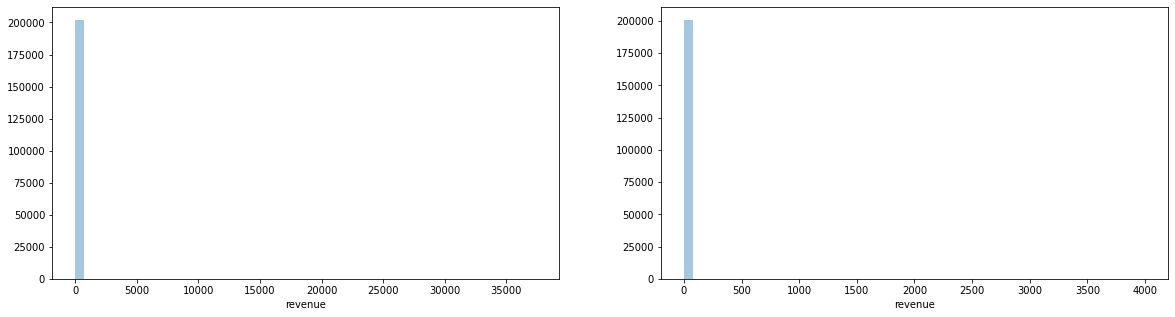

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
sns.distplot(a_group.revenue, kde=False, ax=ax[0])
sns.distplot(b_group.revenue, kde=False, ax=ax[1])


plt.show()

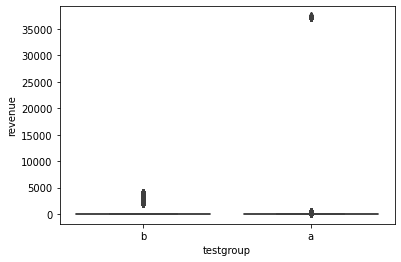

In [19]:
sns.boxplot(x='testgroup', y='revenue', data = test_data)

### Т.к. выборка большая, тест Шапиро-Уилка может дать неточный результат => воспользуемся тестом Колмогорова-Смирнова (адаптирован к большим выборкам)

#### Гипотеза H0: распределение дохода от пользователей в группе а является нормальным
#### Гипотеза H0: распределение дохода от пользователей в группе а не является нормальным

In [20]:
kstest(a_group.revenue, 'norm')

KstestResult(statistic=0.5, pvalue=0.0)

#### p-value < 0.05 => распределение не является нормальным

#### Гипотеза H0: распределение дохода от пользователей в группе b является нормальным
#### Гипотеза H0: распределение дохода от пользователей в группе b не является нормальным

In [21]:
kstest(b_group.revenue, 'norm')

KstestResult(statistic=0.5, pvalue=0.0)

#### p-value < 0.05 => распределение не является нормальным

In [22]:
a_group_pay.describe()

,user_id,revenue
count,1928.000000,1928.000000
mean,200152.677905,2663.998444
std,116596.504905,9049.039763
min,73.000000,200.000000
25%,99323.000000,257.000000
50%,199854.500000,311.000000
75%,299664.250000,361.000000
max,404768.000000,37433.000000


#### Заметим большой размах в доходе в группе a

In [23]:
b_group_pay.describe()

,user_id,revenue
count,1805.000000,1805.000000
mean,205834.548476,3003.658172
std,116400.045485,572.619709
min,161.000000,2000.000000
25%,106815.000000,2513.000000
50%,206651.000000,3022.000000
75%,304907.000000,3478.000000
max,404526.000000,4000.000000


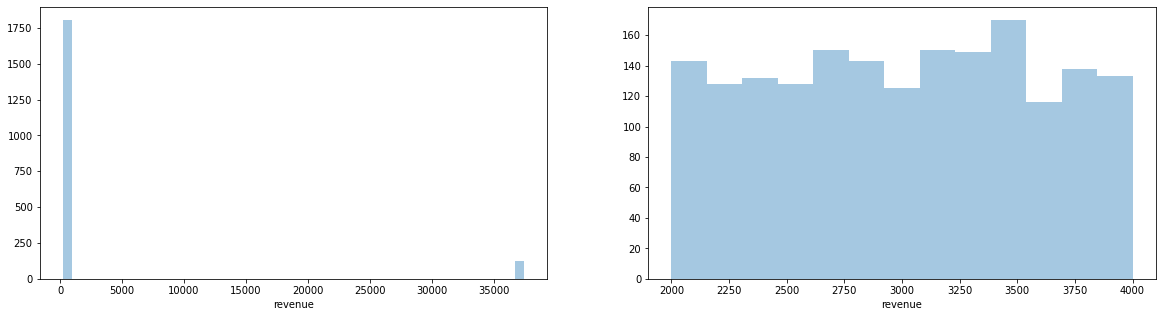

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
sns.distplot(a_group_pay.revenue, kde=False, ax=ax[0])
sns.distplot(b_group_pay.revenue, kde=False, ax=ax[1])

plt.show()

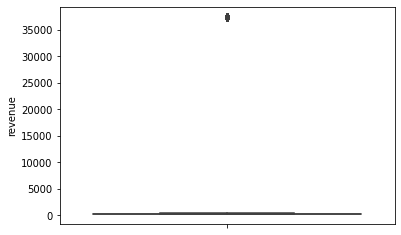

In [25]:
sns.boxplot(y = a_group_pay.revenue)

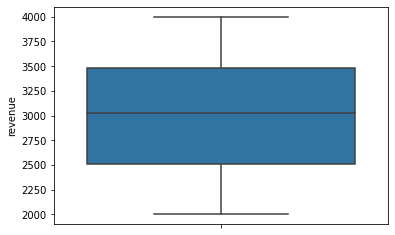

In [26]:
sns.boxplot(y = b_group_pay.revenue)

#### Гипотеза H0: распределение дохода от платящих пользователей в группе а является нормальным
#### Гипотеза H0: распределение дохода от платящих пользователей в группе а не является нормальным

In [27]:
kstest(a_group_pay.revenue, 'norm')

KstestResult(statistic=1.0, pvalue=0.0)

#### p-value < 0.05 => распределение не является нормальным

#### Гипотеза H0: распределение дохода от платящих пользователей в группе b является нормальным
#### Гипотеза H0: распределение дохода от платящих пользователей в группе b не является нормальным

In [28]:
kstest(b_group_pay.revenue, 'norm')

KstestResult(statistic=1.0, pvalue=0.0)

#### p-value < 0.05 => распределение не является нормальным

#### Вывод: для заключения о том, какой набор выкатить, внутри каждой группы стоит рассматривать именно платящих пользователей

### В группе a среди платящих пользователей есть те, кто приносит крайне высокий доход. Рассмотрим их подробнее

In [29]:
a_group_outliers = a_group_pay[(a_group_pay.revenue <= (257 - 1.5*(361 - 257))) | (a_group_pay.revenue >= (361 + 1.5*(361 - 257)))]
b_group_outliers = b_group_pay[(b_group_pay.revenue <= (2513 - 1.5*(3478 - 2513))) | (b_group_pay.revenue >= (3478 + 1.5*(3478 - 2513)))]

In [30]:
print(a_group_outliers.shape[0])
print(b_group_outliers.shape[0])

123
0


In [31]:
print(round(a_group_outliers.revenue.sum()/a_group_pay.revenue.sum(), 2))
print(b_group_outliers.revenue.sum()/b_group_pay.revenue.sum())

0.89
0.0


#### Вывод: в группе а есть 123 пользователя, которые конкретно в этой группе приносят крайне высокий доход и чья доля доходов составляет 89% от общего дохода. Значит, мы должны учитывать этих пользователей.

### Для того, чтобы понять, какой набор следует выкатить, между группами сравним 3 метрики: ARPU, ARPPU, Conversion Rate

#### Т.к. распределение дохода платящих пользователей в обеих группах ненормальное, воспользуемся бутстрапом (его работа не опирается на распределение)

In [32]:
def get_bootstrap(
    data_column_1, 
    data_column_2, 
    boot_it = 1000, 
    statistic = np.mean, # нас интересует среднее
    bootstrap_conf_level = 0.95 
):
    boot_data = []
    for i in tqdm(range(boot_it)): 
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True 
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

### ARPU

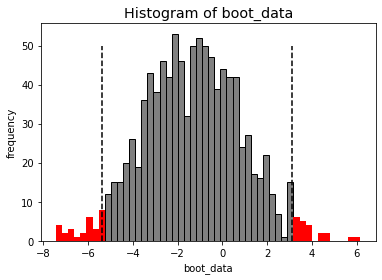

In [33]:
booted_data = get_bootstrap(a_group.revenue, b_group.revenue)

#### Гипотеза H0: ARPU в 2 группах статистически значимо не различаются
#### Гипотеза H1: ARPU в 2 группах статистически значимо различаются

In [34]:
print('p-value is equal to', booted_data["p_value"])
print('quantiles are', booted_data["quants"])

p-value is equal to 0.5419773283023164
quantiles are               0
0.025 -5.382738
0.975  3.118761


#### Бутстрап показал, что между распределениями в двух группах существует статистически незначимое различие (p-value сильно больше 0.05) + 0 входит в ДИ 

### ARPPU

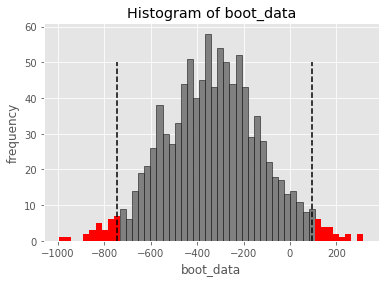

In [35]:
booted_data = get_bootstrap(a_group_pay.revenue, b_group_pay.revenue)

#### Гипотеза H0: ARPPU в 2 группах статистически значимо не различаются
#### Гипотеза H1: ARPPU в 2 группах статистически значимо различаются

In [36]:
print('p-value is equal to', booted_data["p_value"])
print('quantiles are', booted_data["quants"])

p-value is equal to 0.11392118720898595
quantiles are                 0
0.025 -746.382469
0.975   95.446745


#### Бутстрап показал, что между распределениями в двух группах существует статистически незначимое различие (p-value больше 0.05) + 0 входит в ДИ 

### Conversion Rate

In [37]:
print(f'Conversion Rate in group a is equal to {round(a_group_pay.shape[0]/a_group.shape[0]*100, 2)}%')
print(f'Conversion Rate in group b is equal to {round(b_group_pay.shape[0]/b_group.shape[0]*100, 2)}%')

Conversion Rate in group a is equal to 0.95%
Conversion Rate in group b is equal to 0.89%


### Выводы
Сравнение метрик (ARPU, ARPPU, Conversion Rate) с помощью статистических тестов не дали значимых результатов, а значит, основываясь на данных A/B теста, нельзя точно сказать, какой из аукционных наборов стоит выкатывать. Возможно, что при распределении пользователей по экспериментальным группам возникла ошибка, поскольку в группе а оказались 123 пользователя, которые приносят большую часть доходов, в то время как в группе b оказались пользователи, принесшие равномерный доход. Поэтому заказчику рекомендуется скорректировать систему сплитования так, чтобы пользователи в обеих группах характеризовались схожим поведением, тогда можно будет сделать надежные выводы.

### Задание 3

#### Поскольку в таких типах игр на поведение пользователей влияет сложность уровней, были выбраны метрики, которые смогут показать степень сложности и уровень удовлетворенности игрой среди пользователей

ОХВАТ - общее количество уникальных пользователей, участвовавших в тематическом событии

ПРОЦЕНТ ПОПАДАНИЯ НА УРОВЕНЬ - конверсия пользователей в новый уровень

СРЕДНЕЕ ВРЕМЯ, ЗАТРАЧЕННОЕ НА ПРОХОЖДЕНИЕ УРОВНЯ - показатель того, насколько сложным оказался тот или иной уровень для пользователей

RETENTION RATE - важная метрика, демонстрирующая удовлетворенность тематическим событием; можно посчитать по когортам с датой первого захода пользователя на тематическое событие (если событие длится неделю, то RR можно посчитать по дням)

CHURN RATE - показывает, какой процент пользователей перестали участвовать в тематическом событии; CR = 1 - RR

DAU, WAU, MAU - в зависимости от длительности тематического события можно узнать количество уникальных пользователей, участвовавших в тематическом событии за день/неделю/месяц

ПРОДОЛЖИТЕЛЬНОСТЬ СЕССИИ - в зависимости от длительности тематического события можно узнать среднее время нахождения пользователей в игре и сравнить данную метрику со средним временем, проведенным пользователями в игре без событий

ARPU, ARPPU - если в тематическом событии существует возможность покупок, то можно посчитать средний доход с пользователей (всех и только платящих)

#### При каждой неудачной попытке выполнения уровня игрок откатывается на несколько уровней назад. Как тогда поменяются метрики?

В данном случае целесообразнее считать время, затраченное на прохождение уровня в среднем для каждого пользователя, поскольку если оставить расчет метрики, как в предыдущем случае, то один и тот же пользователь будет учитываться несколько раз.

Процент попадания на уровень теперь лучше заменить на процент отката на уровень, чтобы проследить, прохождение какого уровня в большем числе случаев заканчивается неуспехом.

Остальные метрики остаются неизменнными.